In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, IBMQ, Aer, __qiskit_version__
from qiskit.circuit.library import QFT, GraphState, GroverOperator
from qiskit.qasm import pi

import numpy as np
import matplotlib.pyplot as plt
import os.path

from src.utils import *
from src.benchmarks import grover, qaoa, ghz, qft, qftentangled, shor, wstate, qpeinexact, qpeexact, graphstate, vqe, deutschjozsa, hhl, ae, qwalk
from src.benchmarks.qiskit_application_optimization import routing, tsp
from src.benchmarks.qiskit_application_finance import portfolioqaoa, portfoliovqe, pricingcall, pricingput
from src.benchmarks.qiskit_application_ml import qgan

from qiskit.test.mock import FakeBogota, FakeCasablanca, FakeGuadalupe, FakeMontreal, FakeManhattan

In [36]:
# provider = IBMQ.load_account()
# backend = provider.backend.ibmq_santiago
# c_map = backend.configuration().coupling_map

In [37]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ['rx','rz','cz']

In [38]:
benchmarks = [graphstate, grover, qaoa, ghz, qft, wstate, qpeinexact, qpeexact, vqe, deutschjozsa, hhl, shor, ae, qwalk, qftentangled]
#benchmarks_application = [vehicle_routing, travelling_salesman, portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt, qgan]
benchmarks_application = [portfolioqaoa, portfoliovqe, pricingcall, pricingput, qgan]
#benchmarks = [grover, qwalk]
benchmarks_application = []

In [39]:
n_min = 3
n_max = 10
stepsize = 4
num_qubits_test = 5
save_hist = False
save_png = False
simulator = Aer.get_backend('qasm_simulator')
ibm_smallest_fitting = True #smallest fitting architecture-> True, biggest architecture-> False
ancillary_mode="noancilla"

In [41]:
characteristics = []
gate_sets = [(ibm_native_gates, "ibm"), (rigetti_native_gates, "rigetti")]

for benchmark in benchmarks+benchmarks_application:
    
    if benchmark == shor or benchmark == hhl:
        continue
    print(benchmark)
    for n in range(n_min, n_max, stepsize):  
        
        # Creating the circuit on Algorithmic Description Layer
        if (benchmark == grover or benchmark == qwalk):
            qc = benchmark.create_circuit(n, ancillary_mode=ancillary_mode)
            qc.name = qc.name + "-" + ancillary_mode
        else:
            qc = benchmark.create_circuit(n)

        filename = qc.name + "_algorithm_" + str(n) 

        if not (os.path.isfile("qpy_output/" + filename + '.qpy')): 
            serialize_qc(qc, n, filename) 
            if save_png: save_circ(qc, filename)
            if save_hist: sim_and_print_hist(qc, simulator, filename)

            depth = qc.depth()
            characteristics.append([qc, n, depth]) 
        else: print("qpy_output/" + filename + '.qpy' + " already existed")

        # Creating the circuit on target-independent Description Layer
        filename = qc.name + "_t-indep_" + str(n) 
        if not (os.path.isfile("qpy_output/" + filename + '.qpy')): 
            target_independent = transpile(qc, optimization_level=2)
            serialize_qc(target_independent, n, filename)   
            if save_png: save_circ(qc, filename)
            if save_hist: sim_and_print_hist(qc, simulator, filename)

            depth = target_independent.depth()
            characteristics.append([target_independent, n, depth]) 
        else: print("qpy_output/" + filename + '.qpy' + " already existed")  
        
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                # Creating the circuit on target-dependent: native gates layer
                filename_transpiled = qc.name + "_transpiled_" + gate_set_name + "_opt" + str(opt_level) + "_"+ str(n)                     
                if (not (os.path.isfile("qasm_output/" + filename_transpiled + '.qasm')) or benchmark==grover or benchmark==qwalk): 
                    compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=gate_set)
                    n_actual = compiled_without_architecure.num_qubits
                    filename_transpiled = qc.name + "_transpiled_" + gate_set_name + "_opt" + str(opt_level) + "_"+ str(n_actual) 
                    save_as_qasm(compiled_without_architecure, n, filename_transpiled , gate_set, opt_level)  
                    if save_png: save_circ(compiled_without_architecure, filename_transpiled)   
                    if save_hist: sim_and_print_hist(compiled_without_architecure, simulator, filename_transpiled)

                    depth = compiled_without_architecure.depth()
                    characteristics.append([filename_transpiled, n, depth]) 
                #else: print("qasm_output/" + filename_transpiled + '.qasm' + " already existed")

                # Creating the circuit on target-dependent: mapped layer
                n_actual = QuantumCircuit.from_qasm_file("qasm_output/" + filename_transpiled + '.qasm').num_qubits

                if gate_set_name == "rigetti":
                    c_map = get_rigetti_c_map()
                    backend_name = "32 qubits"
                    gate_set_name_mapped = gate_set_name
                elif gate_set_name == "ibm":
                    if ibm_smallest_fitting:
                        if n_actual <= 5: backend = FakeBogota()
                        elif n_actual <= 7: backend = FakeCasablanca()
                        elif n_actual <= 16: backend = FakeGuadalupe()
                        elif n_actual <= 27: backend = FakeMontreal()
                        elif n_actual <= 65: backend = FakeManhattan()
                        gate_set_name_mapped = gate_set_name + "-s"
                    else: 
                        backend = FakeManhattan()
                        gate_set_name_mapped = gate_set_name + "-b"

                    c_map = backend.configuration().coupling_map
                    backend_name = backend.name()
                else:
                    raise ValueError("Gate Set Error")
                max_n_arch = max(max(c_map)) + 1 # +1 because indexing starts at 0 

                if (n_actual <= max_n_arch):

                    filename_mapped = qc.name + "_mapped_" + gate_set_name_mapped + "_opt" + str(opt_level) + "_"+ str(n_actual) 
                    if (not (os.path.isfile("qasm_output/" + filename_mapped + '.qasm')) or benchmark==grover or benchmark==qwalk): 

                        compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level, 
                                                                          basis_gates=gate_set, c_map=c_map)
                        save_as_qasm(compiled_with_architecture, n, filename_mapped, gate_set, 
                                     opt_level, True, c_map, gate_set_name_mapped + "-" + backend_name)

                        if save_png: save_circ(compiled_with_architecture, filename_mapped)
                        if save_hist: sim_and_print_hist(compiled_with_architecture, simulator, filename_mapped)

                        depth = compiled_with_architecture.depth()
                        characteristics.append([filename_mapped, n, depth])
                #else: print("qasm_output/" + filename_mapped + '.qasm' + " already existed")


            #except:
                #print("\n Problem occured: ", benchmark, n, gate_set_name, index)
                #pass

            
## Todo: Anpassung der benchmarks, wo n != num qubits ist
#create_shor_benchmarks()
#create_hhl_benchmarks()
#create grover + qwalk with mxc-mode = "v-chain"
#application: optimization, nature

<module 'src.benchmarks.graphstate' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/graphstate.py'>
qpy_output/graphstate_algorithm_3.qpy already existed
qpy_output/graphstate_t-indep_3.qpy already existed
qpy_output/graphstate_algorithm_7.qpy already existed
qpy_output/graphstate_t-indep_7.qpy already existed
<module 'src.benchmarks.grover' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/grover.py'>
qpy_output/grover-noancilla_algorithm_3.qpy already existed
qpy_output/grover-noancilla_t-indep_3.qpy already existed
qpy_output/grover-noancilla_algorithm_7.qpy already existed
qpy_output/grover-noancilla_t-indep_7.qpy already existed
<module 'src.benchmarks.qaoa' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/qaoa.py'>
<module 'src.benchmarks.ghz' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/ghz.py'>
<module 'src.benchmarks.qft' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/qft.py'>
<module 'src.benchmarks.wstate' from '/Users/

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_8285/3267951884.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  characteristics = np.array(characteristics)


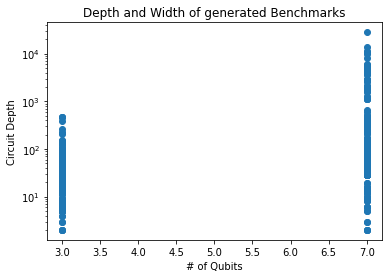

In [42]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:,1].astype(int), y=characteristics[:,2].astype(int))
plt.yscale('log')
plt.title('Depth and Width of generated Benchmarks')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth');

In [8]:
def create_shor_benchmarks():
    small = [15,4] #18 qubits
    medium = [821, 4] #42 qubits
    large = [11777, 4] #58 qubits
    xlarge = [201209, 4] # 74 qubits
    benchmark_list = [small]#, medium, large, xlarge]
    for n, a in benchmark_list:        
        
        # Creating the circuit on Algorithmic Description Layer
        qc = shor.create_circuit(n,a)
        num_qubits = str(len(qc.qubits))
        filename = qc.name + "_algorithm_" +  str(num_qubits) 
        serialize_qc(qc, num_qubits, filename) 
        if save_png: save_circ(qc, filename)
            
        # Creating the circuit on target-independent Description Layer
        target_independent = transpile(qc, optimization_level=2)
        filename = qc.name + "_t-indep_" + num_qubits
        serialize_qc(target_independent, num_qubits, filename)          
        if save_png: save_circ(qc, filename)
            
        # Creating the circuit on target-dependent: native gates layer
        compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=basis_gates)
        num_qubits = str(len(compiled_without_architecure.qubits))
        filename_transpiled = qc.name + "_transpiled_" + gate_set_name + "_opt" + str(opt_level) + "_"+ num_qubits
        save_as_qasm(compiled_without_architecure, num_qubits, filename_transpiled , basis_gates, opt_level)  
        
        depth = compiled_without_architecure.depth()        
        characteristics.append([filename, num_qubits, depth])
        
        if save_png: save_circ(compiled_without_architecure, filename)       
        if save_hist:
            sim_and_print_hist(compiled_without_architecure, simulator, filename)
        
        # Creating the circuit on target-dependent: mapped layer
        if (int(num_qubits) < max_n_arch):
            compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level,
                                                              basis_gates=basis_gates, c_map=c_map)
            num_qubits = str(len(compiled_with_architecture.qubits))
            filename_mapped = qc.name + "_mapped_" + gate_set_name + "_opt" + str(opt_level) + "_" + num_qubits
            save_as_qasm(compiled_with_architecture, num_qubits, filename_mapped, basis_gates, 
                         opt_level, True, c_map, backend.name() if backend.name() else "")
            
            depth = compiled_with_architecture.depth()
            characteristics.append([filename, num_qubits, depth])
            if save_png: save_circ(compiled_with_architecture, filename)
            
            if save_hist:
                sim_and_print_hist(compiled_with_architecture, simulator, filename)

In [9]:
def create_hhl_benchmarks():
    # n is not the number of qubits in this case
    for n in range(1,2):         
        
        # Creating the circuit on Algorithmic Description Layer
        qc = hhl.create_circuit(n)
        num_qubits = str(len(qc.qubits))
        filename = qc.name + "_algorithm_" + str(num_qubits)
        serialize_qc(qc, num_qubits, filename)          
        if save_png: save_circ(qc, filename)
            
        # Creating the circuit on target-independent Description Layer
        target_independent = transpile(qc, optimization_level=2)
        filename = qc.name + "_t-indep_" + num_qubits
        serialize_qc(target_independent, num_qubits, filename)          
        if save_png: save_circ(qc, filename)
        
        # Creating the circuit on target-dependent: native gates layer
        compiled_without_architecure = get_compiled_circuit(qc = qc, opt_level=opt_level, basis_gates=basis_gates)
        num_qubits = str(len(compiled_without_architecure.qubits))
        filename_transpiled = qc.name + "_transpiled_" + gate_set_name + "_opt" + str(opt_level) + "_"+ num_qubits
        save_as_qasm(compiled_without_architecure, num_qubits, filename_transpiled , basis_gates, opt_level)           
        
        depth = compiled_without_architecure.depth()        
        characteristics.append([filename, num_qubits, depth])
        if save_png: save_circ(compiled_without_architecure, filename)  
        
        if save_hist:
            sim_and_print_hist(compiled_without_architecure, simulator, filename)
        
        # Creating the circuit on target-dependent: mapped layer
        if (int(num_qubits) < max_n_arch):
            compiled_with_architecture = get_compiled_circuit(qc = qc, opt_level=opt_level, 
                                                              basis_gates=basis_gates, c_map=c_map)
            
            num_qubits = str(len(compiled_with_architecture.qubits))
            
            filename_mapped = qc.name + "_mapped_" + gate_set_name + "_opt" + str(opt_level) + "_"+ str(num_qubits) 
            save_as_qasm(compiled_with_architecture, num_qubits, filename_mapped, basis_gates, 
                         opt_level, True, c_map, backend.name() if backend.name() else "")
            
            depth = compiled_with_architecture.depth()
            characteristics.append([filename, num_qubits, depth])
            if save_png: save_circ(compiled_with_architecture, filename)
            
            if save_hist:
                sim_and_print_hist(compiled_with_architecture, simulator, filename)

Grover Test

In [10]:
a = grover.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

NameError: name 'basis_gates' is not defined

In [ ]:
a = grover.create_circuit(12, "recursion")
basis_gates = ['rx','rz','cz']
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
print(a.num_qubits, b.num_qubits)

QAOA Test

In [ ]:
a = qaoa.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

GHZ Test

In [ ]:
a = ghz.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QFT Test

In [ ]:
a = qft.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QFT Entangled Test

In [ ]:
a = qft_entangled.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

W-State Test

In [ ]:
a = w_state.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

QPE Exact and QPE Inexact Test

In [ ]:
a = qpe_exact.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

a = qpe_inexact.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Graph State Test

In [ ]:
a = graph_state.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")


Shor Test

In [ ]:
a = shor.create_circuit(15)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, None, basis_gates)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, None, True)

AE Test

In [ ]:
a = ae.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

DJ Test

In [ ]:
num_qubits_test = 5
a = deutsch_jozsa.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

HHL Test

In [ ]:
import src.benchmarks.hhl
num_qubits_test = 3
a = hhl.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Example Generation for a figure in the paper

In [ ]:
#from qiskit.circuit.library import RealAmplitudes
#from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
#plot_gate_map(backend).savefig("layout_santiago.png")
#ansatz = RealAmplitudes(3, reps=1)
#qc = ansatz.decompose()
#qc.draw(output="mpl", filename="paper_example_1_1")
#b = get_compiled_circuit(qc, opt_level=0, basis_gates=basis_gates)
#b.draw(output="mpl", filename="paper_example_1_2")
#c = get_compiled_circuit(b, opt_level=0, basis_gates=basis_gates, c_map=c_map)
#c.draw(output="mpl", filename="paper_example_1_3")

Qiskit Finance Test

In [ ]:

from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt
num_qubits_test = 5
a = pricing_eur_put_opt.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Qiskit Optimization Test

In [ ]:

from src.benchmarks.qiskit_application_optimization import vehicle_routing
num_qubits_test = 5
a = vehicle_routing.create_circuit(3,3)
#b = get_compiled_circuit(a, opt_level=2)
#save_as_qasm(b, num_qubits_test)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, num_qubits_test, True)

Qiskit Machine Learning Test

In [ ]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [3]
k = len(num_qubits)

In [ ]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
)

# Set entangler map
#entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz",  reps=1) #entanglement=entangler_map,

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3.0, 1.0, 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [ ]:
# Run qGAN
result = qgan.run(quantum_instance)

In [ ]:
params = qgan.generator.parameter_values

In [ ]:
params = qgan.generator.parameter_values
qc = qgan.generator.construct_circuit(params=params)
qc.draw()

In [ ]:
qgan.generator.generator_circuit.draw()

In [ ]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

AE Test

In [ ]:
from src.benchmarks import canonical_ae


In [ ]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

In [ ]:
a = canonical_ae.create_circuit(5)
a.draw()

TSP and vehicle routing Test

In [ ]:
from src.benchmarks.qiskit_application_optimization import travelling_salesman, vehicle_routing

In [ ]:
qc = vehicle_routing.create_circuit(4,1)

In [ ]:
qc1, qp1 = vehicle_routing.create_circuit(4,2)

In [ ]:
qc2, qp2  = vehicle_routing.create_circuit(4,3)

In [ ]:
qc3, qp3  = vehicle_routing.create_circuit(4,4)

In [ ]:
from qiskit.quantum_info import Statevector
print(Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc2)),
Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc3)),
Statevector.from_instruction(qc3).equiv(Statevector.from_instruction(qc2)))

QGAN Test

In [ ]:
from src.benchmarks.qiskit_application_ml import qgan

In [ ]:
a = qgan.create_circuit(4)

In [ ]:
a.decompose().draw()

In [ ]:
qc.draw()

Qiskit Application Finance Test

In [ ]:
from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt

In [ ]:
b = portfolio_optimization_qaoa.create_circuit(5)

In [ ]:
b.draw()

In [ ]:
c = portfolio_optimization_vqe.create_circuit(4)
c.draw()

In [ ]:
d = pricing_eur_call_opt.create_circuit(4)
d.draw()

In [ ]:
e, iae = pricing_eur_put_opt.create_circuit(2)
e.draw()

In [ ]:
test1 = iae.construct_circuit(1)
test1.decompose().decompose().decompose().draw()

In [ ]:
test2 = iae.construct_circuit(2)
test2.decompose().decompose().decompose().draw()

In [ ]:
test1 == test2

Qiskit Application Nature Test

In [ ]:
## Code from https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.algorithms import GroundStateEigensolver

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
vqe_solver = VQEUCCFactory(quantum_instance)


calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)

print(res)

In [ ]:
vqe_solver.get_solver(es_problem, qubit_converter).get_optimal_circuit()

In [ ]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory
from qiskit_nature.algorithms import ExcitedStatesEigensolver

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())


# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
solver = VQEUCCFactory(quantum_instance)
gsc = GroundStateEigensolver(qubit_converter, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver
qeom_excited_states_calculation = QEOM(gsc, "sd")


qeom_results = qeom_excited_states_calculation.solve(es_problem)

Random debugging

In [ ]:
qc = grover.create_circuit(5)
qc.decompose().draw()

In [ ]:
qc2 = transpile(qc, optimization_level=2)
qc2.decompose().draw()

In [ ]:
qc==qc2

In [ ]:
# Creating the circuit on Algorithmic Description Layer
qc = grover.create_circuit(11, ancillary_mode="noancilla")



In [ ]:
qc.draw()

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import GroverOperator
from qiskit.qasm import pi
from qiskit.algorithms import Grover

# checked
n=5
ancillary_mode = 'noancilla'
    
n = n - 1  # magic number due to the flag qubit
q = QuantumRegister(n, 'q')
flag = AncillaRegister(1, 'flag')

state_preparation = QuantumCircuit(q, flag)
state_preparation.h(q)
state_preparation.x(flag)
print("state_preparation qubits:", oracle.num_qubits)

oracle = QuantumCircuit(q, flag)
oracle.mcp(pi, q, flag)
print("oracle qubits:", oracle.num_qubits)

operator = GroverOperator(oracle)

print("num qubits operator: ", operator.num_qubits)
iterations = Grover.optimal_num_iterations(1, n)

num_qubits = operator.num_qubits


# num_qubits may differe now depending on the mcx_mode

q2 = QuantumRegister(num_qubits-1, 'q')
qc = QuantumCircuit(q2, flag, name='grover')

print("num qubits qc: ", qc.num_qubits)
qc.compose(state_preparation, inplace=True)
print(qc.draw())

qc.compose(operator.power(iterations), inplace=True)
qc.measure_all()
print("end qubits:", qc.num_qubits)
qc.draw()

In [ ]:
def create_circuit(n: int):
    from qiskit.algorithms import Grover
    n=n-1
    q = QuantumRegister(n, 'q')
    flag = AncillaRegister(1, 'flag')
    c = ClassicalRegister(n)

    state_preparation = QuantumCircuit(q, flag)
    state_preparation.h(q)
    state_preparation.x(flag)

    oracle = QuantumCircuit(q, flag)
    oracle.mcp(pi, q, flag)

    operator = GroverOperator(oracle)
    print("num qubits operator: ", operator.num_qubits)
    iterations = Grover.optimal_num_iterations(1, n)

    qc = QuantumCircuit(q, flag, c, name='grover')
    print("num qubits qc: ", qc.num_qubits)
    qc.compose(state_preparation, inplace=True)

    qc.compose(operator.power(iterations), inplace=True)
    qc.measure_all()
    print("end qubits:", qc.num_qubits)

    return qc
create_circuit(5).num_qubits
create_circuit(5).draw()

In [11]:
f1 = "qpy_output/qpeexact_algorithm_3.qpy"
f2 = "qpy_output/qpeexact_t-indep_3.qpy"

In [12]:
with open(f1, 'rb') as fd:
    a = qpy_serialization.load(fd)[0]
with open(f2, 'rb') as fd:
    b = qpy_serialization.load(fd)[0]

In [15]:
a==b

True

In [30]:
a = qwalk.create_circuit(7, ancillary_mode="v-chain")
a.draw()

┌────┐                                 ┌────┐                  »
 node_0: ─────┤0   ├─────────────────────────────────┤0   ├──────────────────»
              │    │┌────┐┌───┐                      │    │┌────┐┌───┐       »
 node_1: ─────■    ├┤0   ├┤ X ├──────────────────────■    ├┤0   ├┤ X ├───────»
              │    ││    │├───┴┐┌───┐                │    ││    │├───┴┐┌───┐ »
 node_2: ─────■    ├■    ├┤0   ├┤ X ├────────────────■    ├■    ├┤0   ├┤ X ├─»
              │    ││    ││    │├───┴┐┌───┐          │    ││    ││    │├───┴┐»
 node_3: ─────■    ├■    ├■    ├┤0   ├┤ X ├──────────■    ├■    ├■    ├┤0   ├»
              │    ││    ││    ││    │├───┤┌───┐     │    ││    ││    ││    │»
 node_4: ─────■    ├■    ├■    ├■    ├┤ X ├┤ X ├─────■    ├■    ├■    ├■    ├»
              │    ││    ││    ││    │└─┬─┘├───┤┌───┐│    ││    ││    ││    │»
 node_5: ─────■  X ├■  X ├■  X ├■  X ├──■──┤ X ├┤ X ├■  X ├■  X ├■  X ├■  X ├»
         ┌───┐│    ││    ││    ││    │  │  └─┬─┘├───┤│    ││    ││    ││    │»
   coin: ┤ H ├■    ├■    ├■    ├■    ├──■────■──┤ X ├■    ├■    ├■    ├■    ├»
         └───┘│    ││    ││    ││    │          └───┘│    ││    ││    ││    │»
  anc_0: ─────┤1   ├┤1   ├┤1   ├┤1   ├───────────────┤1   ├┤1   ├┤1   ├┤1   ├»
              │    ││    ││    │└────┘               │    ││    ││    │└────┘»
  anc_1: ─────┤2   ├┤2   ├┤2   ├─────────────────────┤2   ├┤2   ├┤2   ├──────»
              │    ││    │└────┘                     │    ││    │└────┘      »
  anc_2: ─────┤3   ├┤3   ├───────────────────────────┤3   ├┤3   ├────────────»
              │    │└────┘                           │    │└────┘            »
  anc_3: ─────┤4   ├─────────────────────────────────┤4   ├──────────────────»
              └────┘                                 └────┘                  »
meas: 11/════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ░ ┌─┐                              
« node_0: ────────────────░─┤M├──────────────────────────────
«                         ░ └╥┘┌─┐                           
« node_1: ────────────────░──╫─┤M├───────────────────────────
«                         ░  ║ └╥┘┌─┐                        
« node_2: ────────────────░──╫──╫─┤M├────────────────────────
«         ┌───┐           ░  ║  ║ └╥┘┌─┐                     
« node_3: ┤ X ├───────────░──╫──╫──╫─┤M├─────────────────────
«         ├───┤┌───┐      ░  ║  ║  ║ └╥┘┌─┐                  
« node_4: ┤ X ├┤ X ├──────░──╫──╫──╫──╫─┤M├──────────────────
«         └─┬─┘├───┤┌───┐ ░  ║  ║  ║  ║ └╥┘┌─┐               
« node_5: ──■──┤ X ├┤ X ├─░──╫──╫──╫──╫──╫─┤M├───────────────
«           │  └─┬─┘├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐            
«   coin: ──■────■──┤ X ├─░──╫──╫──╫──╫──╫──╫─┤M├────────────
«                   └───┘ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
«  anc_0: ────────────────░──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
«                         ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
«  anc_1: ────────────────░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
«                         ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
«  anc_2: ────────────────░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
«                         ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
«  anc_3: ────────────────░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
«                         ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
«meas: 11/═══════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
«                            0  1  2  3  4  5  6  7  8  9  10

In [31]:
b = transpile(a, optimization_level=2)

ValueError: too many subscripts in einsum